# US Election Map
A map of us presedential election results through time

In [1]:
#Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import json
import datetime

from shapely.geometry import Polygon, mapping
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth

## US Shape File

In [4]:
#Get US states shapefile
us_shape = gpd.read_file('../data/States 21basic/geo_export_65f74268-7da4-45cb-b582-640700c3c767.shp')
us_shape = us_shape[['state_name','geometry']]
us_shape.head()

,state_name,geometry
0,Hawaii,(POLYGON ((-160.0738033454681 22.0041773479577...
1,Washington,(POLYGON ((-122.4020153103836 48.2252163723779...
2,Montana,POLYGON ((-111.4754253002074 44.70216236909688...
3,Maine,(POLYGON ((-69.77727626137293 44.0741483685119...
4,North Dakota,POLYGON ((-98.73043728833767 45.93827137024809...


In [5]:
#plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=3) 
choropleth =folium.GeoJson(data= us_shape.to_json())
m.add_child(choropleth)

In [6]:
#Get election data
election = pd.read_csv("../data/1976-2016-president.csv" )
election.replace('democratic-farmer-labor','democrat',inplace=True)
election.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
0,1976,Alabama,AL,1,63,41,US President,"Carter, Jimmy",democrat,False,659170,1182850,20171015,NaN
1,1976,Alabama,AL,1,63,41,US President,"Ford, Gerald",republican,False,504070,1182850,20171015,NaN
2,1976,Alabama,AL,1,63,41,US President,"Maddox, Lester",american independent party,False,9198,1182850,20171015,NaN
3,1976,Alabama,AL,1,63,41,US President,"Bubar, Benjamin """"Ben""""",prohibition,False,6669,1182850,20171015,NaN
4,1976,Alabama,AL,1,63,41,US President,"Hall, Gus",communist party use,False,1954,1182850,20171015,NaN


In [9]:
# Transform election data 
states = set(election['state'])

results = {}
for year in range(1976,2020,4):
    
    result = {}
    for state in states:
        
        state_year = election[(election.year == year) 
                              & (election.state == state)]
        dem = max(state_year[state_year.party == 'democrat']['candidatevotes'])
        rep = max(state_year[state_year.party == 'republican']['candidatevotes'])
        
        result[state] = {'dem':dem, 'rep':rep}
        
    results[year] = result
    
results

{1976: {'Virginia': {'dem': 813896, 'rep': 836554},
  'North Dakota': {'dem': 136078, 'rep': 153684},
  'Nevada': {'dem': 92479, 'rep': 101273},
  'Minnesota': {'dem': 1070440, 'rep': 819395},
  'Maine': {'dem': 232279, 'rep': 236320},
  'New York': {'dem': 3244165, 'rep': 2825913},
  'California': {'dem': 3742284, 'rep': 3882244},
  'Maryland': {'dem': 759612, 'rep': 672661},
  'South Carolina': {'dem': 450807, 'rep': 346149},
  'New Mexico': {'dem': 201148, 'rep': 211419},
  'District of Columbia': {'dem': 137818, 'rep': 27873},
  'Texas': {'dem': 2082319, 'rep': 1953300},
  'Hawaii': {'dem': 147375, 'rep': 140003},
  'Georgia': {'dem': 979409, 'rep': 483743},
  'Vermont': {'dem': 77798, 'rep': 100387},
  'Wyoming': {'dem': 62239, 'rep': 92717},
  'New Jersey': {'dem': 1444653, 'rep': 1509688},
  'Connecticut': {'dem': 647895, 'rep': 719261},
  'Colorado': {'dem': 460801, 'rep': 584278},
  'Wisconsin': {'dem': 1040232, 'rep': 1004987},
  'Kansas': {'dem': 430421, 'rep': 502752},
  'M

## 2016 Results

In [10]:
def state_style(state,year=2016,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = results[year][state]
    
    if state_results['dem'] >= state_results['rep']:
        color = '#4f7bff' #blue
    else:
        color = '#ff5b4f' #red
    
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,function=True)
    
    return style

In [11]:
#plot the choropleth 
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map
choropleth =folium.GeoJson(data= us_shape.to_json(),style_function=style_function)
m.add_child(choropleth)

## Year Slider 

In [26]:
def year_to_ts(year):
    """
    Convert year to timestamp
    """
    time = datetime.datetime(year, 1, 1, 0, 0).strftime('%s')
    if len(time)==9: time ='0{}'.format(time)
    return time

def style_dictionary():
    """
    style_dictionary used by the TimeSliderChoropleth folium function
    """
    
    # get ids used by TimeSliderChoropleth
    ID = {}
    state_json = json.loads(us_shape.to_json())

    for state in state_json['features']:
        state_id = state['id']
        state_name = state['properties']['state_name']
        ID[state_name] = state_id
    
    
    #create style dictionary
    style_dic= {}
    for state in states:
        
        state_dic = {}
        for year in range(1976,2020,4):
            
            time = year_to_ts(year)
            state_dic[time] =  state_style(state,year)

        style_dic[ID[state]] = state_dic  
        
    return style_dic

In [28]:
# Create time slider map
m = folium.Map(location=[50.77500, -100],zoom_start=3) 
ts = TimeSliderChoropleth(us_shape.to_json(), style_dictionary())
m.add_child(ts)

m.save("../figures/us_election_map1.html")

## State Buttons

In [37]:
def marker_style(feature): 
    """
    style_function choropleth buttons
    """

    return {'fillOpacity': 0,
             'weight': 1,
             'fillColor': '#000000',
             'color': '#000000'}   

def highlight_style(feature): 
    """
    style_function used when choropleth button
    is highighted
    """
    return {'fillOpacity': 0.2,
         'weight': 1,
         'fillColor': '#000000',
         'color': '#000000'}  

def getFigure(state):
    """
    Plot voting trends from a given state
    """

    #Get number of votes
    years = range(1976,2020,4)
    dems = []
    reps =[]
    for year in years:

        result = results[year][state]
        dems.append(result['dem']/1000000)  
        reps.append(result['rep']/1000000) 

    #Plot number of votes    
    fig = plt.figure(figsize=(8,4))
    plt.plot(years,dems,label='Democrat',color='#4f7bff')
    plt.plot(years,reps,label='Republican',color='#ff5b4f')

    plt.title(state,size = 18)
    plt.ticklabel_format(style='plain')
    plt.xlabel('Year',size =14)
    plt.xticks(years)
    plt.ylabel('Votes (millions)',size =14)
    plt.legend(loc =0)

    #Add figure to iframe
    html = mpld3.fig_to_html(fig)
    iframe = folium.IFrame(html=html,width = 600, height = 300)

    return iframe

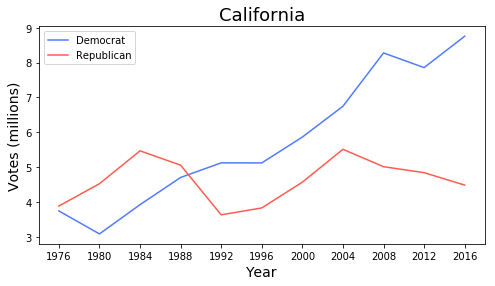

In [36]:
state = 'California'

years = range(1976,2020,4)
dems = []
reps =[]
for year in years:

    result = results[year][state]
    dems.append(result['dem']/1000000)  
    reps.append(result['rep']/1000000) 

#Plot number of votes    
fig = plt.figure(figsize=(8,4))
plt.plot(years,dems,label='Democrat',color='#4f7bff')
plt.plot(years,reps,label='Republican',color='#ff5b4f')

plt.title(state,size = 18)
plt.ticklabel_format(style='plain')
plt.xlabel('Year',size =14)
plt.xticks(years)
plt.ylabel('Votes (millions)',size =14)
plt.legend(loc =0)

plt.savefig('../figures/california_trends.png',format='png',dpi=150)

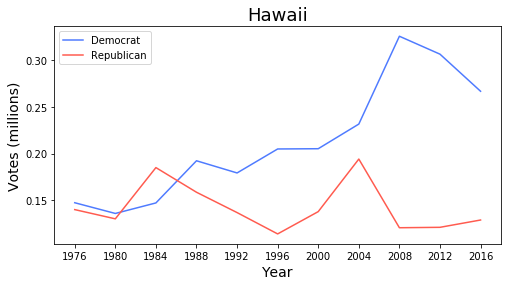

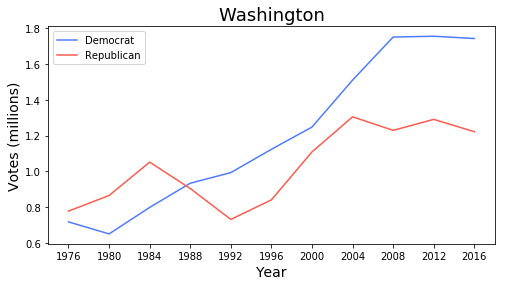

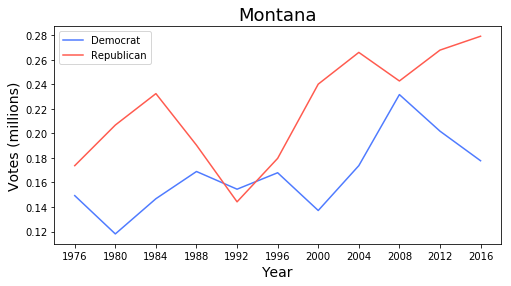

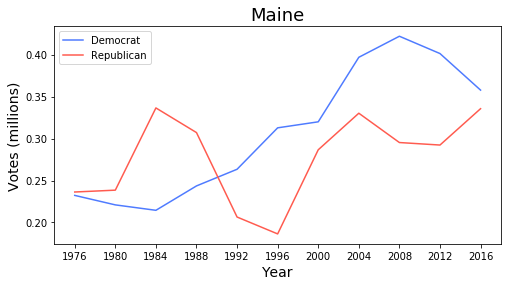

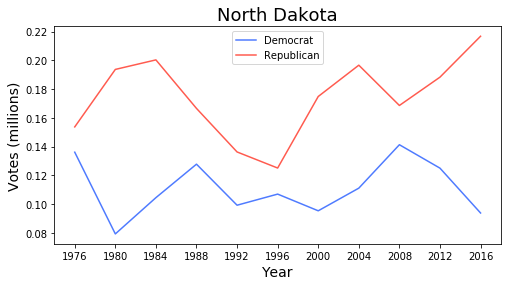

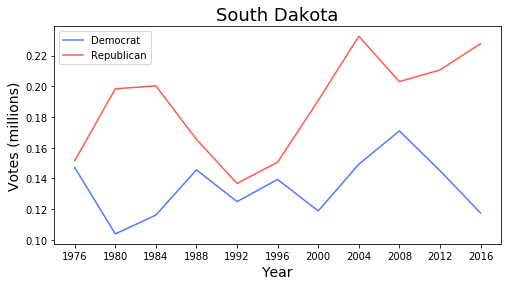

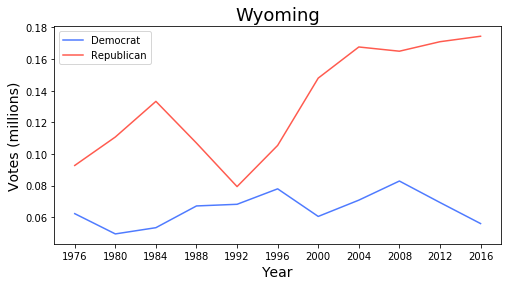

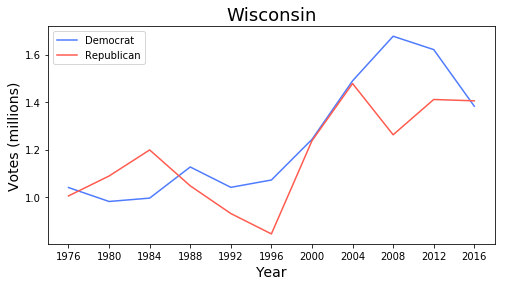

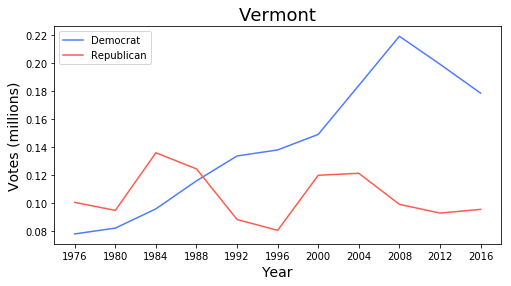

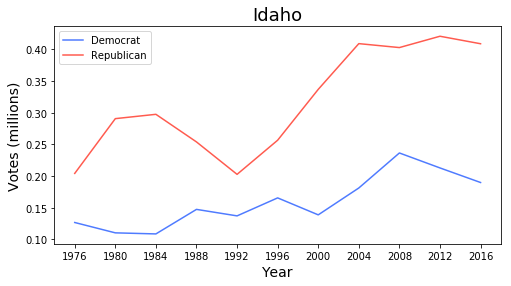

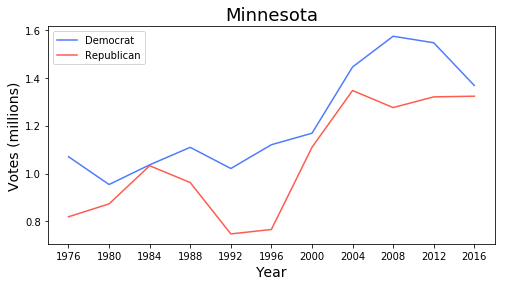

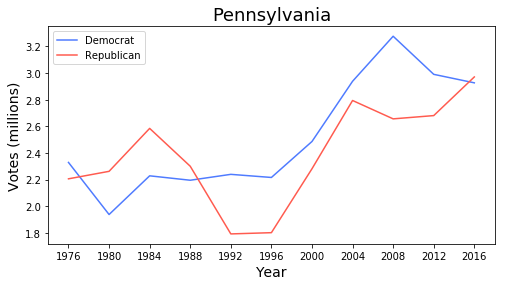

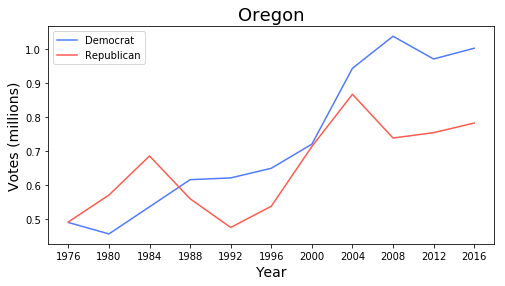

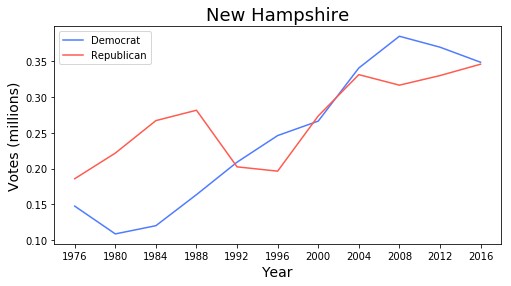

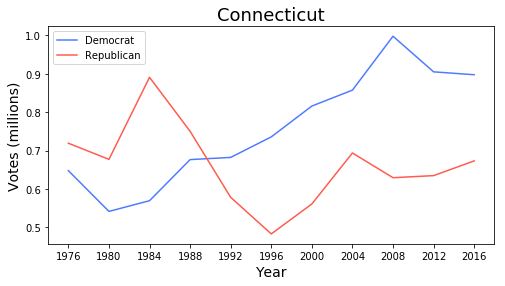

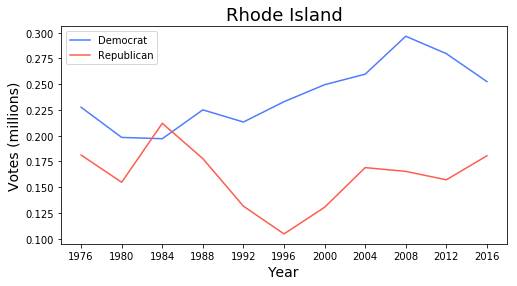

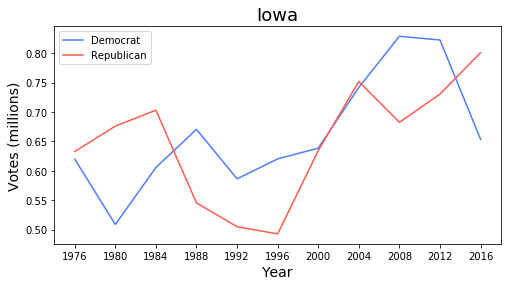

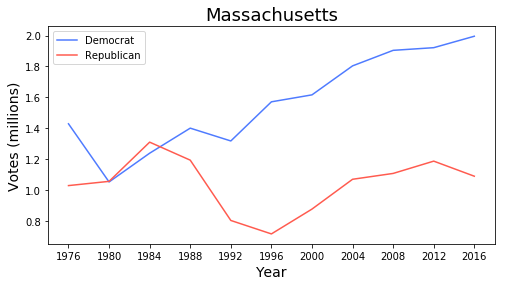

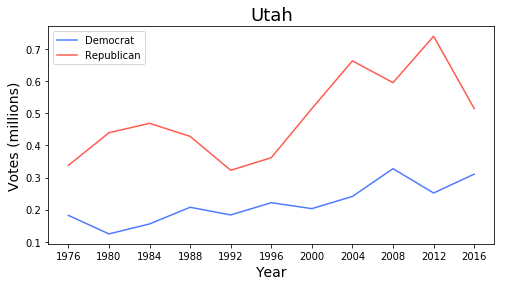

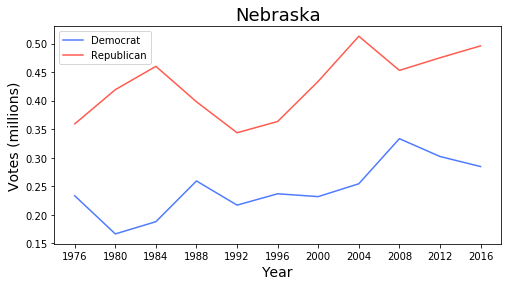

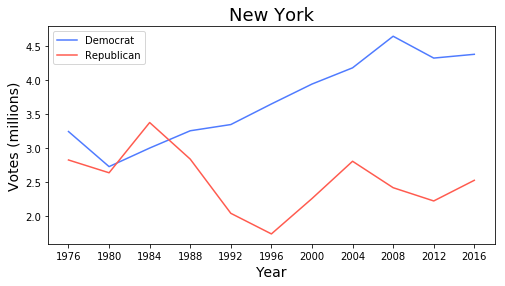

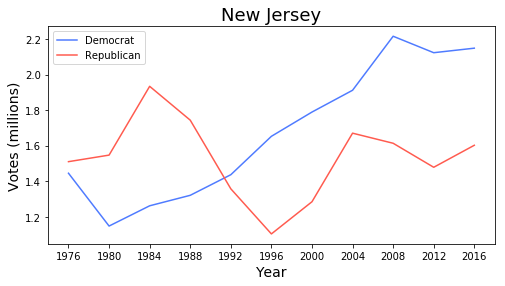

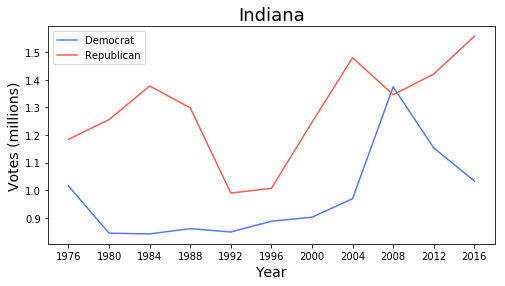

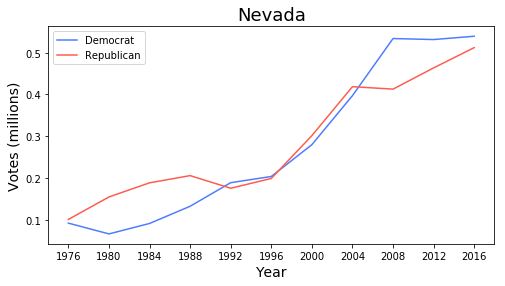

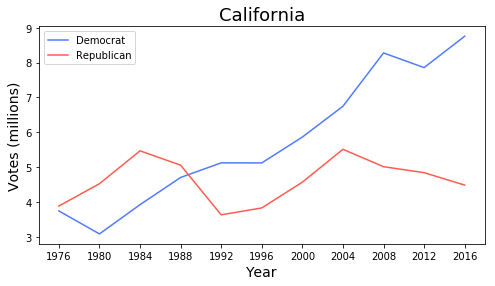

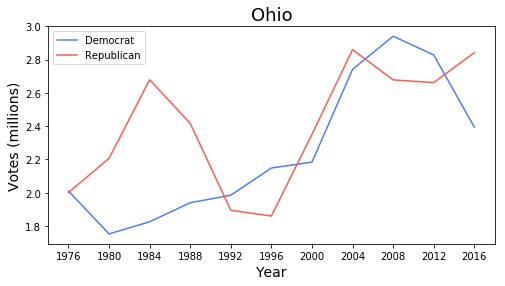

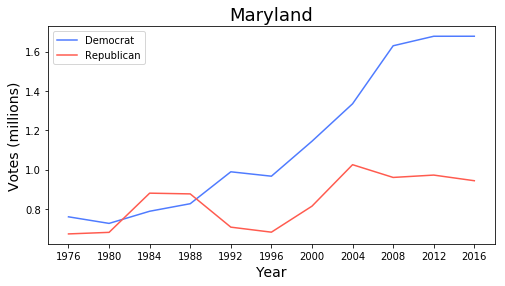

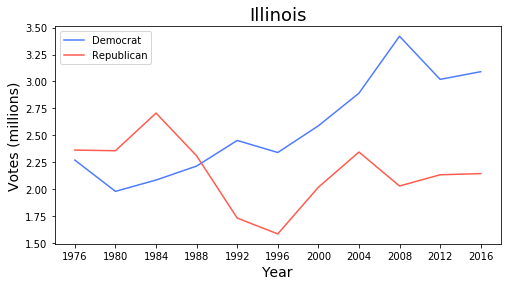

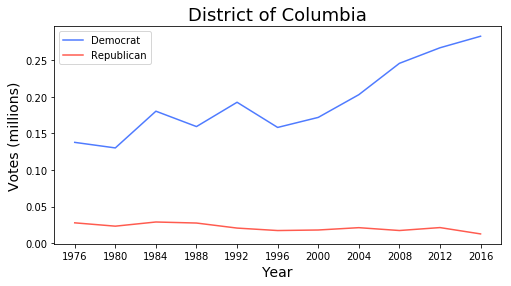

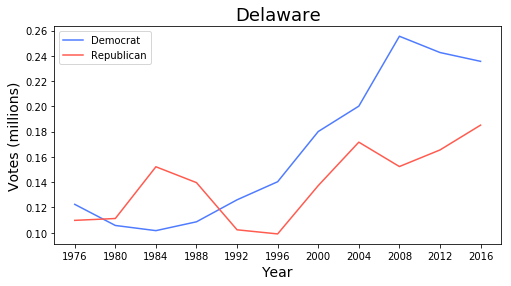

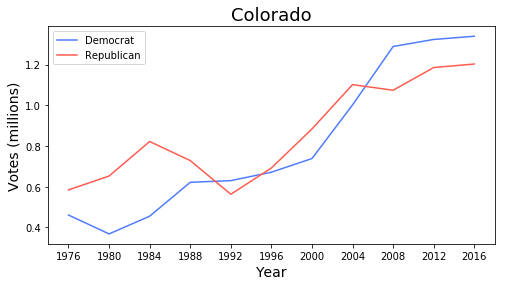

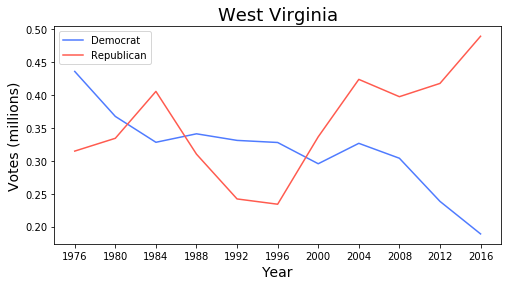

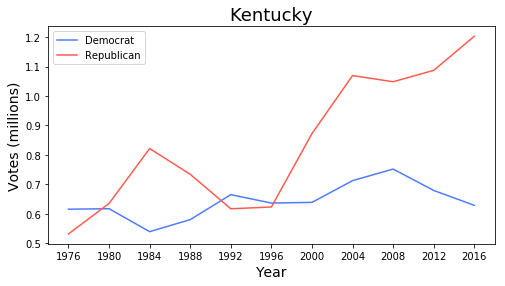

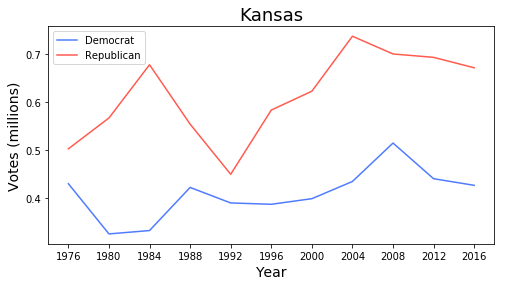

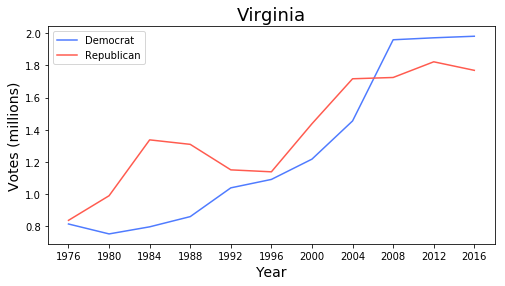

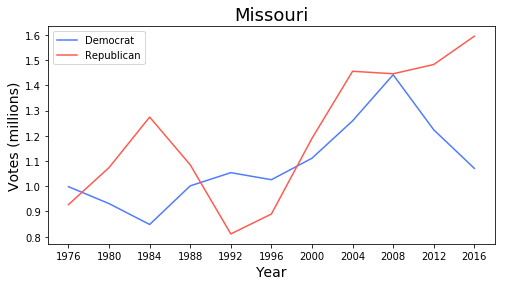

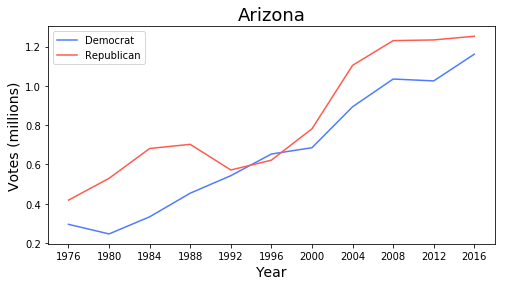

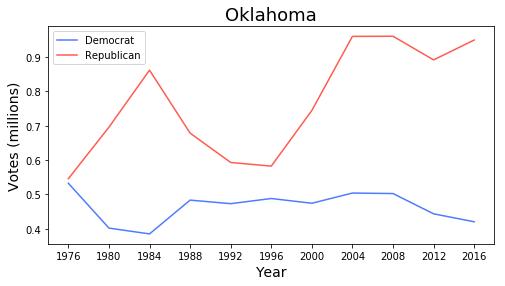

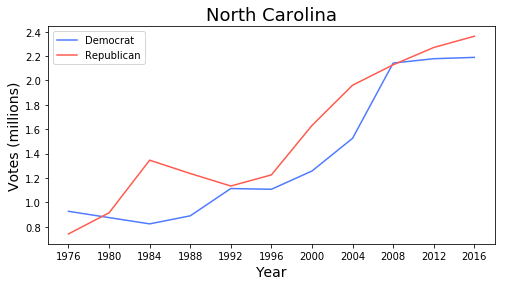

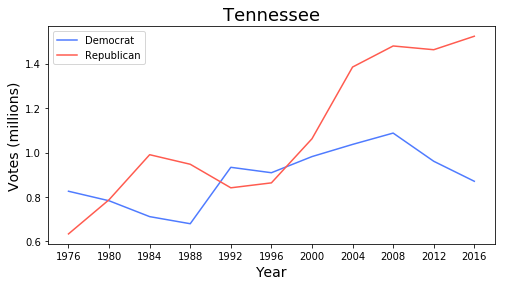

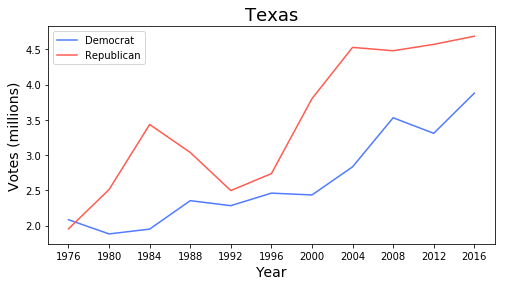

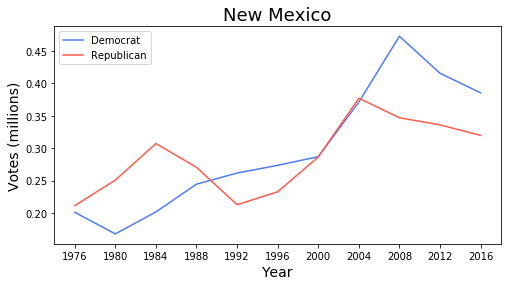

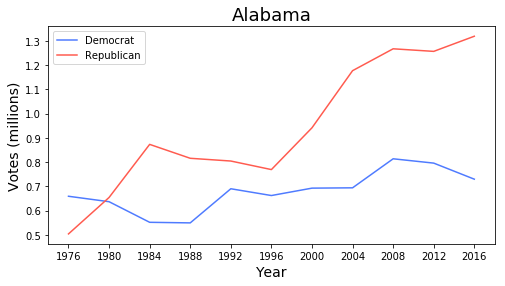

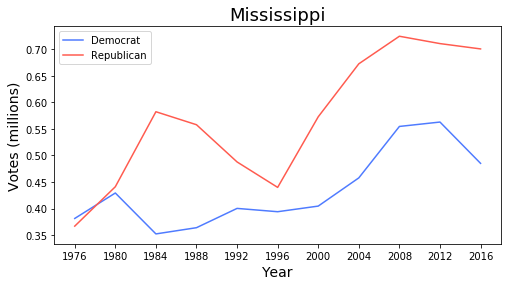

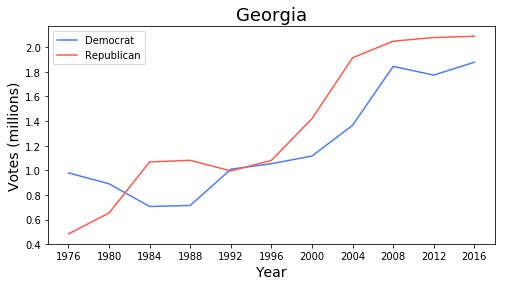

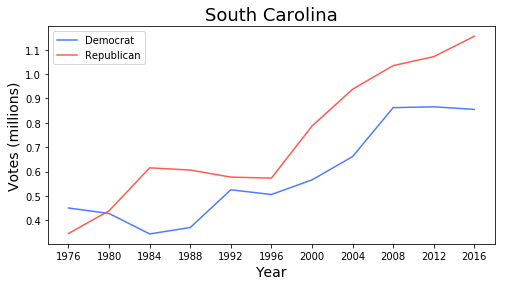

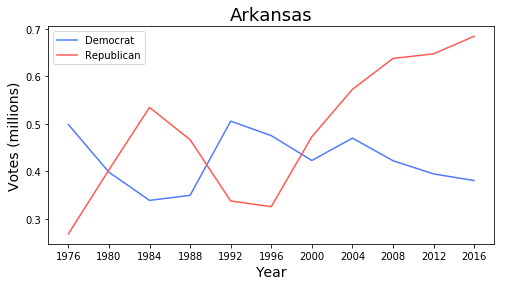

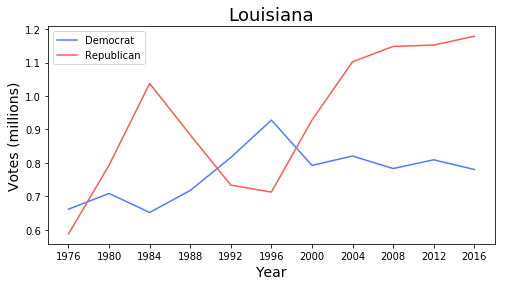

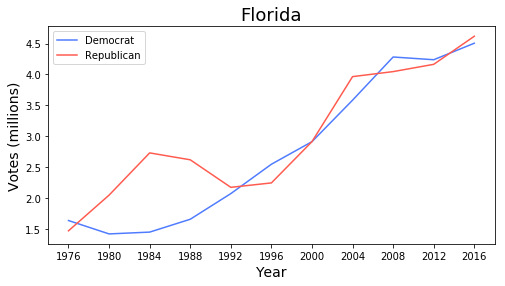

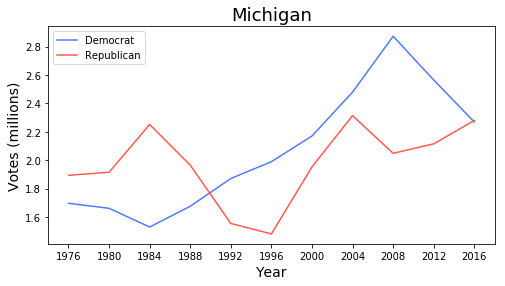

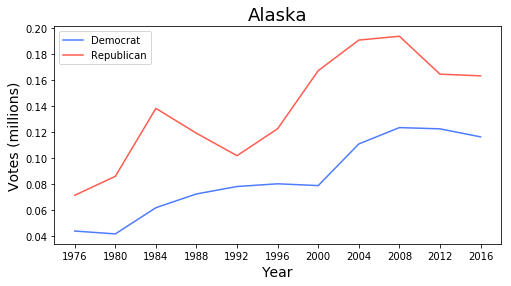

In [39]:
#plot the shape file with folium 
m = folium.Map(location=[50.77500, -100],zoom_start=5,max_zoom=5) #Initialize map
choropleth =folium.GeoJson(data= us_shape.to_json(),
                           style_function=style_function)
m.add_child(choropleth)

#Create popup button for each state
for i in range(len(us_shape)):
    
    geometry = us_shape.loc[i]['geometry']
    state_name = us_shape.loc[i]['state_name']
    popup = folium.Popup(getFigure(state_name),max_width=1000)
    
    state_marker = folium.GeoJson(data=mapping(geometry),
                                  style_function = marker_style,
                                  highlight_function = highlight_style)
    state_marker.add_child(popup)
    m.add_child(state_marker)

m.save("../figures/us_election_map2.html")

# Cover Image

In [44]:
# Create time slider map
m = folium.Map(location=[50.77500, -100],zoom_start=3,
               tiles='http://{s}.tiles.mapbox.com/v3/mapbox.control-room/{z}/{x}/{y}.png',
   attr='Mapbox attribution') 
ts = TimeSliderChoropleth(us_shape.to_json(), style_dictionary())
m.add_child(ts)

m.save("../figures/us_cover.html")